In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from numba import jit, prange, njit
from blimpy import Waterfall
import time
import random
import datetime
from synthetic import create_true, create_full_cadence, create_false, create_true_single_shot, create_true_faster
from scipy import spatial
from numpy import dot
from numpy.linalg import norm
import math
import json
import sys
import os
sys.path.insert(1, '../ML_Training')
sys.path.insert(2, '../GBT_pipeline')
from preprocess import get_data
from single_search import search_model_eval, combine

os.environ["TF_CONFIG"] = json.dumps({
    "cluster": {
        "chief": ["10.10.10.88:8000"],
        "worker": [ "10.10.10.86:8000"],
    },
   "task": {"type": "chief", "index": 0}
})

In [ ]:
%matplotlib inline
NUM_SAMPLES = 10000
plate = np.load('../../filtered.npy')

@jit(nopython=True)
def pre_proc(data):
    data = np.log(data)
    data= data - data.min()
    data = data/data.max()
    return data

@jit(parallel=True)
def load_data_ED(data):
    print(data.shape)
    data_transform =  np.zeros((data.shape[0],6, 16,256,1))
    for i in prange(data.shape[0]):
        data_transform[i,:,:,:,0]  = pre_proc(data[i,:,:,:] )
    return data_transform

def combine(data):
    new_data = np.zeros((data.shape[0]*data.shape[1],data.shape[2],data.shape[3],data.shape[4]))
    for i in prange(data.shape[0]):
        new_data[i*data.shape[1] : (i+1)*data.shape[1],:,:,:] = data[i,:,:,:,:]
    return new_data

data = abs(create_full_cadence(create_true_faster, plate = plate, samples =  NUM_SAMPLES, snr_base=300, snr_range=20,factor=1))
start = time.time()
data = combine(load_data_ED(data))
print(data.shape)

true_data = abs(create_full_cadence(create_true_faster, plate = plate, samples = NUM_SAMPLES*6, snr_base=300, snr_range=20, factor=1))
start = time.time()
true_data = load_data_ED(true_data)

cadence_set = ['../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_58929_GJ380_fine.h5',
                "../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_59291_HIP48887_fine.h5",
                "../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_59650_GJ380_fine.h5",
                "../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_60004_HIP48924_fine.h5",
                "../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_60354_GJ380_fine.h5",
                "../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_60706_HIP48954_fine.h5"
                ]

false_data_1 = get_data(cadence_set, 1543, 1578)
false_data_0 = abs(create_full_cadence(create_false, plate = plate, samples = NUM_SAMPLES*6, snr_base=300, snr_range=20))
start = time.time()
false_data_0 = load_data_ED(false_data_0)

false_data = np.concatenate((false_data_1[:30000],false_data_0[:30000]), axis=0)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
(10000, 6, 16, 256)
(60000, 16, 256, 1)
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000


In [101]:
NUM_SAMPLES_TEST=1000
data_test = abs(create_full_cadence(create_true_faster, plate = plate, samples =  NUM_SAMPLES_TEST, snr_base=300, snr_range=20,factor=1))
start = time.time()
data_test = combine(load_data_ED(data_test))
print(data_test.shape)

true_data_test = abs(create_full_cadence(create_true_faster, plate = plate, samples = NUM_SAMPLES_TEST*6, snr_base=300, snr_range=20, factor=1))
start = time.time()
true_data_test = load_data_ED(true_data_test)

cadence_set = ['../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_58929_GJ380_fine.h5',
                "../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_59291_HIP48887_fine.h5",
                "../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_59650_GJ380_fine.h5",
                "../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_60004_HIP48924_fine.h5",
                "../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_60354_GJ380_fine.h5",
                "../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_60706_HIP48954_fine.h5"
                ]
false_data_test_1 = get_data(cadence_set, 1260, 1276)

false_data_test_0 = abs(create_full_cadence(create_false, plate = plate, samples = NUM_SAMPLES_TEST*6, snr_base=300, snr_range=20))
start = time.time()
false_data_test_0 = load_data_ED(false_data_test_0)

false_data_test = np.concatenate((false_data_test_1[:3000],false_data_test_0[:3000]), axis=0)

0
(1000, 6, 16, 256)
(6000, 16, 256, 1)
0
1000
2000
3000
4000
5000
(6000, 6, 16, 256)
Getting Data
reshaping Data
Combining Cadence
Data Load Execution Time: 4.653273105621338
0
1000
2000
3000
4000
5000
(6000, 6, 16, 256)


In [102]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder,  **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.true_loss_tracker = keras.metrics.Mean(name="true_loss")
        self.false_loss_tracker = keras.metrics.Mean(name="false_loss")
        
        self.total_loss_tracker_validation = keras.metrics.Mean(name="val_total_loss")
        self.reconstruction_loss_tracker_validation = keras.metrics.Mean(
            name="val_reconstruction_loss"
        )
        self.kl_loss_tracker_validation = keras.metrics.Mean(name="val_kl_loss")
        self.false_loss_tracker_validation = keras.metrics.Mean(name="val_false_loss")
        self.true_loss_tracker_validation = keras.metrics.Mean(name="val_true_loss")
        
        alpha=100
        beta=1
        self.alpha = alpha
        self.beta = beta
        self.count=1

    @tf.function
    def loss_diff(self, a,b):
        return 1/ self.loss_same(a,b)
   
    @tf.function
    def loss_same(self, a,b):
        return tf.math.reduce_mean(tf.math.reduce_euclidean_norm(a-b, axis=1))

    
    @tf.function
    def true_clustering(self, true_data,training=True):
        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(true_data[:,0,:,:,:], training)[2]
        b = self.encoder(true_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(true_data[:,2,:,:,:],training)[2]
        c = self.encoder(true_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(true_data[:,4,:,:,:], training)[2]
        d = self.encoder(true_data[:,5,:,:,:], training)[2]

        difference += self.loss_diff(a1,b)
        difference += self.loss_diff(a1,c)
        difference += self.loss_diff(a1,d)

        difference += self.loss_diff(a2,b)
        difference += self.loss_diff(a2,c)
        difference += self.loss_diff(a2,d)

        difference += self.loss_diff(a3,b)
        difference += self.loss_diff(a3,c)
        difference += self.loss_diff(a3,d)

        same += self.loss_same(a1,a2)
        same += self.loss_same(a1,a3)
        same += self.loss_same(a2,a3)
        
        same += self.loss_same(b,c)
        same += self.loss_same(c,d)
        same += self.loss_same(b,d)
        

        similarity += 1.5*same+difference
        return similarity
    
    @tf.function
    def false_clustering(self, false_data, training=True):
        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(false_data[:,0,:,:,:], training)[2]
        b = self.encoder(false_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(false_data[:,2,:,:,:],training)[2]
        c = self.encoder(false_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(false_data[:,4,:,:,:], training)[2]
        d = self.encoder(false_data[:,5,:,:,:], training)[2]

        difference += self.loss_same(a1,b)
        difference += self.loss_same(a1,c)
        difference += self.loss_same(a1,d)

        difference += self.loss_same(a2,b)
        difference += self.loss_same(a2,c)
        difference += self.loss_same(a2,d)

        difference += self.loss_same(a3,b)
        difference += self.loss_same(a3,c)
        difference += self.loss_same(a3,d)

        same += self.loss_same(a1,a2)
        same += self.loss_same(a1,a3)
        same += self.loss_same(a2,a3)
        
        same += self.loss_same(b,c)
        same += self.loss_same(c,d)
        same += self.loss_same(b,d)
        
        similarity += 1.5*same+difference
        return similarity
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self, data):
        self.count+=1
        cluster_loss =0
        x, y = data
        true_data = x[1]
        false_data = x[2]
        x= x[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            false_loss = self.false_clustering(false_data)
            true_loss = self.true_clustering(true_data)
            total_loss = reconstruction_loss + self.beta*kl_loss +self.alpha*(3*true_loss+false_loss)
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.false_loss_tracker.update_state(false_loss)
        self.true_loss_tracker.update_state(true_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "false_loss": self.false_loss_tracker.result(),
            "true_loss": self.true_loss_tracker.result()
        }
    
    def test_step(self, data):
        # Unpack the data
        x, y = data
        true_data = x[1]
        false_data = x[2]
        x= x[0]
        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstruction = self.decoder(z, training=False)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        false_loss = self.false_clustering(false_data, False)
        true_loss = self.true_clustering(true_data, False)
        total_loss = reconstruction_loss + self.beta*kl_loss +self.alpha*(3*true_loss+false_loss)
        
        
        self.total_loss_tracker_validation.update_state(total_loss)
        self.reconstruction_loss_tracker_validation.update_state(reconstruction_loss)
        self.kl_loss_tracker_validation.update_state(kl_loss)
        self.false_loss_tracker_validation.update_state(false_loss)
        self.true_loss_tracker_validation.update_state(true_loss)
        
        return {
            "loss": self.total_loss_tracker_validation.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker_validation.result(),
            "kl_loss": self.kl_loss_tracker_validation.result(),
            "false_loss": self.false_loss_tracker_validation.result(),
            "true_loss": self.true_loss_tracker_validation.result()
        }

In [103]:
from tensorflow.python.client import device_lib
gpus = tf.config.experimental.list_physical_devices('GPU')

In [104]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [105]:
def sample_creation(inputs):
    z_mean = inputs[0]
    z_log_var = inputs[1]
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [106]:
def build_model():
    latent_dim = 8
    dens_lay = 512
    kernel = (3,3)
    encoder_inputs = keras.Input(shape=(16, 256, 1))
    x = layers.Conv2D(16, kernel, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(16, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=2,padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(dens_lay, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(dens_lay, activation="relu")(latent_inputs)
    x = layers.Dense(1* 16 * 64, activation="relu")(x)
    x = layers.Reshape((1,16, 64))(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=2,padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, kernel, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()

    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam(lr=0.0005))
    return vae

communication_options = tf.distribute.experimental.CommunicationOptions(
    implementation=tf.distribute.experimental.CommunicationImplementation.NCCL)
strategy = tf.distribute.MultiWorkerMirroredStrategy(
    communication_options=communication_options)

print("Number of devices: {}".format(strategy.num_replicas_in_sync))

with strategy.scope():
    model = build_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
tensorflow      INFO     Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 16, 256, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_144 (Conv2D)             (None, 8, 128, 16)   160         in

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="vae_best_model.h5",
    monitor='val_loss',
    save_weights_only=False,
    mode='min',
    save_best_only=True)

model.fit(x = [data,true_data,false_data ],y= data[:,:,:,:], epochs=1500, batch_size=5000, 
          validation_data=([data_test,true_data_test,false_data_test ], data_test),validation_batch_size=6000)

Epoch 1/1500
12/12 [==============================] - 21s 2s/step - loss: 2502.1555 - reconstruction_loss: 1908.6284 - kl_loss: 66.2423 - false_loss: 0.3984 - true_loss: 1.5762 - val_loss: 2527.4595 - val_reconstruction_loss: 1912.2764 - val_kl_loss: 86.8335 - val_false_loss: 0.5143 - val_true_loss: 1.5897
Epoch 2/1500
12/12 [==============================] - 15s 1s/step - loss: 2479.9503 - reconstruction_loss: 1907.5150 - kl_loss: 68.5605 - false_loss: 0.3983 - true_loss: 1.5762 - val_loss: 2527.4041 - val_reconstruction_loss: 1912.2725 - val_kl_loss: 86.8212 - val_false_loss: 0.5142 - val_true_loss: 1.5896
Epoch 3/1500
12/12 [==============================] - 15s 1s/step - loss: 2437.9723 - reconstruction_loss: 1906.5625 - kl_loss: 69.3089 - false_loss: 0.3983 - true_loss: 1.5761 - val_loss: 2527.3389 - val_reconstruction_loss: 1912.2683 - val_kl_loss: 86.8094 - val_false_loss: 0.5141 - val_true_loss: 1.5895
Epoch 4/1500
12/12 [==============================] - 15s 1s/step - loss: 24

12/12 [==============================] - 15s 1s/step - loss: 2286.2200 - reconstruction_loss: 1905.3887 - kl_loss: 85.7328 - false_loss: 0.3941 - true_loss: 1.5607 - val_loss: 2521.3264 - val_reconstruction_loss: 1912.0580 - val_kl_loss: 86.5335 - val_false_loss: 0.5067 - val_true_loss: 1.5735
Epoch 54/1500
12/12 [==============================] - 15s 1s/step - loss: 2278.7858 - reconstruction_loss: 1904.7941 - kl_loss: 86.0303 - false_loss: 0.3940 - true_loss: 1.5603 - val_loss: 2521.1812 - val_reconstruction_loss: 1912.0537 - val_kl_loss: 86.5316 - val_false_loss: 0.5065 - val_true_loss: 1.5731
Epoch 55/1500
12/12 [==============================] - 15s 1s/step - loss: 2284.2110 - reconstruction_loss: 1905.8688 - kl_loss: 85.8442 - false_loss: 0.3939 - true_loss: 1.5599 - val_loss: 2521.0330 - val_reconstruction_loss: 1912.0508 - val_kl_loss: 86.5286 - val_false_loss: 0.5064 - val_true_loss: 1.5727
Epoch 56/1500
12/12 [==============================] - 15s 1s/step - loss: 2289.7602 - 

12/12 [==============================] - 16s 1s/step - loss: 2246.1821 - reconstruction_loss: 1904.8700 - kl_loss: 95.3612 - false_loss: 0.3870 - true_loss: 1.5375 - val_loss: 2513.2917 - val_reconstruction_loss: 1911.8525 - val_kl_loss: 86.6556 - val_false_loss: 0.4973 - val_true_loss: 1.5502
Epoch 106/1500
12/12 [==============================] - 15s 1s/step - loss: 2251.4276 - reconstruction_loss: 1905.6699 - kl_loss: 92.1989 - false_loss: 0.3869 - true_loss: 1.5371 - val_loss: 2513.1243 - val_reconstruction_loss: 1911.8484 - val_kl_loss: 86.6608 - val_false_loss: 0.4971 - val_true_loss: 1.5497
Epoch 107/1500
12/12 [==============================] - 15s 1s/step - loss: 2238.2068 - reconstruction_loss: 1904.8402 - kl_loss: 95.5835 - false_loss: 0.3867 - true_loss: 1.5366 - val_loss: 2512.9573 - val_reconstruction_loss: 1911.8438 - val_kl_loss: 86.6664 - val_false_loss: 0.4969 - val_true_loss: 1.5492
Epoch 108/1500
12/12 [==============================] - 16s 1s/step - loss: 2238.4172

12/12 [==============================] - 15s 1s/step - loss: 2220.4255 - reconstruction_loss: 1904.5682 - kl_loss: 100.5324 - false_loss: 0.3786 - true_loss: 1.5120 - val_loss: 2504.6985 - val_reconstruction_loss: 1911.6299 - val_kl_loss: 87.0035 - val_false_loss: 0.4871 - val_true_loss: 1.5245
Epoch 158/1500
12/12 [==============================] - 16s 1s/step - loss: 2219.0061 - reconstruction_loss: 1904.7607 - kl_loss: 101.4466 - false_loss: 0.3785 - true_loss: 1.5115 - val_loss: 2504.5312 - val_reconstruction_loss: 1911.6252 - val_kl_loss: 87.0117 - val_false_loss: 0.4869 - val_true_loss: 1.5240
Epoch 159/1500
12/12 [==============================] - 16s 1s/step - loss: 2219.6174 - reconstruction_loss: 1904.6539 - kl_loss: 101.3535 - false_loss: 0.3783 - true_loss: 1.5110 - val_loss: 2504.3655 - val_reconstruction_loss: 1911.6206 - val_kl_loss: 87.0194 - val_false_loss: 0.4867 - val_true_loss: 1.5235
Epoch 160/1500
12/12 [==============================] - 15s 1s/step - loss: 2219.3

12/12 [==============================] - 15s 1s/step - loss: 2209.9204 - reconstruction_loss: 1904.8280 - kl_loss: 104.3179 - false_loss: 0.3703 - true_loss: 1.4871 - val_loss: 2496.3838 - val_reconstruction_loss: 1911.4233 - val_kl_loss: 87.3988 - val_false_loss: 0.4771 - val_true_loss: 1.4995
Epoch 210/1500
12/12 [==============================] - 16s 1s/step - loss: 2211.4029 - reconstruction_loss: 1904.3531 - kl_loss: 103.8172 - false_loss: 0.3702 - true_loss: 1.4866 - val_loss: 2496.2222 - val_reconstruction_loss: 1911.4193 - val_kl_loss: 87.4085 - val_false_loss: 0.4769 - val_true_loss: 1.4990
Epoch 211/1500
12/12 [==============================] - 16s 1s/step - loss: 2209.7798 - reconstruction_loss: 1904.2780 - kl_loss: 103.1150 - false_loss: 0.3700 - true_loss: 1.4861 - val_loss: 2496.0664 - val_reconstruction_loss: 1911.4161 - val_kl_loss: 87.4182 - val_false_loss: 0.4766 - val_true_loss: 1.4986
Epoch 212/1500
12/12 [==============================] - 16s 1s/step - loss: 2221.1

12/12 [==============================] - 16s 1s/step - loss: 2213.9344 - reconstruction_loss: 1905.3711 - kl_loss: 100.8160 - false_loss: 0.3621 - true_loss: 1.4625 - val_loss: 2488.3064 - val_reconstruction_loss: 1911.2249 - val_kl_loss: 87.8666 - val_false_loss: 0.4672 - val_true_loss: 1.4750
Epoch 262/1500
12/12 [==============================] - 16s 1s/step - loss: 2228.4362 - reconstruction_loss: 1905.1429 - kl_loss: 100.3192 - false_loss: 0.3619 - true_loss: 1.4621 - val_loss: 2488.1538 - val_reconstruction_loss: 1911.2212 - val_kl_loss: 87.8751 - val_false_loss: 0.4670 - val_true_loss: 1.4745
Epoch 263/1500
12/12 [==============================] - 15s 1s/step - loss: 2211.6399 - reconstruction_loss: 1904.9492 - kl_loss: 105.3656 - false_loss: 0.3618 - true_loss: 1.4616 - val_loss: 2488.0000 - val_reconstruction_loss: 1911.2173 - val_kl_loss: 87.8836 - val_false_loss: 0.4669 - val_true_loss: 1.4740
Epoch 264/1500
12/12 [==============================] - 15s 1s/step - loss: 2206.9

12/12 [==============================] - 15s 1s/step - loss: 2212.0914 - reconstruction_loss: 1904.7500 - kl_loss: 104.3278 - false_loss: 0.3539 - true_loss: 1.4384 - val_loss: 2480.5161 - val_reconstruction_loss: 1911.0278 - val_kl_loss: 88.3713 - val_false_loss: 0.4579 - val_true_loss: 1.4511
Epoch 314/1500
12/12 [==============================] - 15s 1s/step - loss: 2200.7406 - reconstruction_loss: 1904.4862 - kl_loss: 106.7573 - false_loss: 0.3538 - true_loss: 1.4379 - val_loss: 2480.3682 - val_reconstruction_loss: 1911.0245 - val_kl_loss: 88.3815 - val_false_loss: 0.4577 - val_true_loss: 1.4506
Epoch 315/1500
12/12 [==============================] - 16s 1s/step - loss: 2201.6354 - reconstruction_loss: 1904.4135 - kl_loss: 107.3252 - false_loss: 0.3536 - true_loss: 1.4375 - val_loss: 2480.2214 - val_reconstruction_loss: 1911.0205 - val_kl_loss: 88.3913 - val_false_loss: 0.4575 - val_true_loss: 1.4502
Epoch 316/1500
12/12 [==============================] - 16s 1s/step - loss: 2197.3

12/12 [==============================] - 15s 1s/step - loss: 2200.4478 - reconstruction_loss: 1906.6146 - kl_loss: 107.5722 - false_loss: 0.3468 - true_loss: 1.4173 - val_loss: 2473.6479 - val_reconstruction_loss: 1910.9503 - val_kl_loss: 88.7682 - val_false_loss: 0.4493 - val_true_loss: 1.4300
Epoch 366/1500
12/12 [==============================] - 16s 1s/step - loss: 2204.6090 - reconstruction_loss: 1906.7871 - kl_loss: 107.2822 - false_loss: 0.3466 - true_loss: 1.4169 - val_loss: 2473.5083 - val_reconstruction_loss: 1910.9479 - val_kl_loss: 88.7787 - val_false_loss: 0.4491 - val_true_loss: 1.4296
Epoch 367/1500
12/12 [==============================] - 16s 1s/step - loss: 2200.9084 - reconstruction_loss: 1905.7999 - kl_loss: 106.7231 - false_loss: 0.3465 - true_loss: 1.4165 - val_loss: 2473.3699 - val_reconstruction_loss: 1910.9456 - val_kl_loss: 88.7876 - val_false_loss: 0.4490 - val_true_loss: 1.4291
Epoch 368/1500
12/12 [==============================] - 16s 1s/step - loss: 2198.3

12/12 [==============================] - 16s 1s/step - loss: 2190.5364 - reconstruction_loss: 1904.0179 - kl_loss: 110.0130 - false_loss: 0.3391 - true_loss: 1.3948 - val_loss: 2466.5107 - val_reconstruction_loss: 1910.7749 - val_kl_loss: 89.2885 - val_false_loss: 0.4405 - val_true_loss: 1.4080
Epoch 418/1500
12/12 [==============================] - 16s 1s/step - loss: 2194.7694 - reconstruction_loss: 1905.6244 - kl_loss: 106.9210 - false_loss: 0.3390 - true_loss: 1.3944 - val_loss: 2466.3760 - val_reconstruction_loss: 1910.7722 - val_kl_loss: 89.2988 - val_false_loss: 0.4403 - val_true_loss: 1.4076
Epoch 419/1500
12/12 [==============================] - 15s 1s/step - loss: 2192.0714 - reconstruction_loss: 1904.6381 - kl_loss: 109.7835 - false_loss: 0.3388 - true_loss: 1.3940 - val_loss: 2466.2412 - val_reconstruction_loss: 1910.7692 - val_kl_loss: 89.3090 - val_false_loss: 0.4402 - val_true_loss: 1.4072
Epoch 420/1500
12/12 [==============================] - 16s 1s/step - loss: 2191.8

In [108]:
model.encoder.save("VAE-ENCODERv30.h5")
model.decoder.save("VAE-DECODERv14.h5")

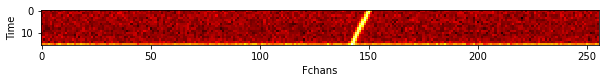

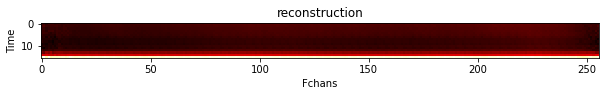

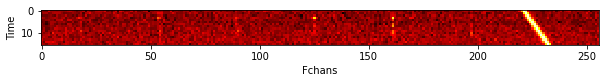

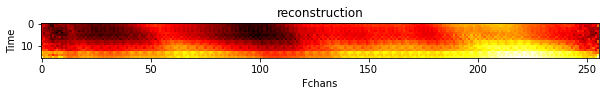

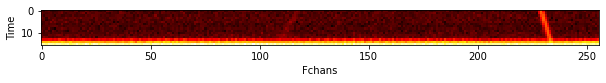

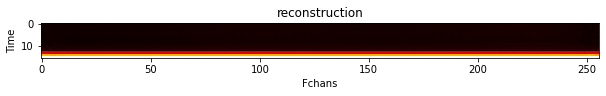

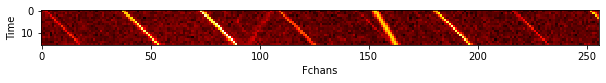

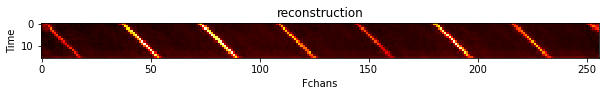

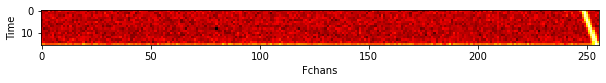

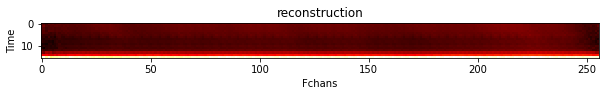

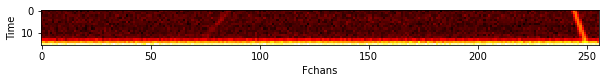

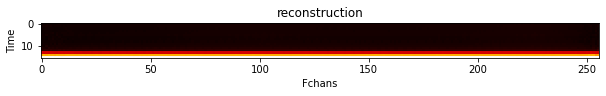

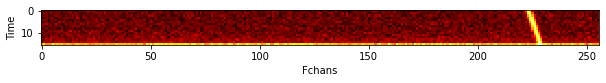

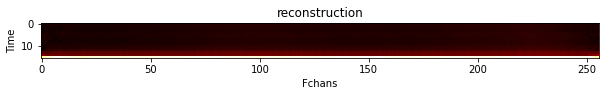

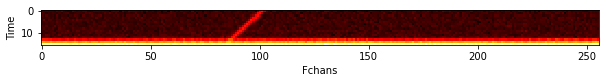

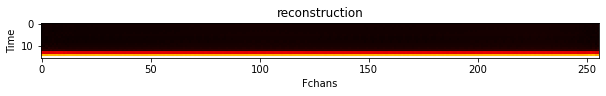

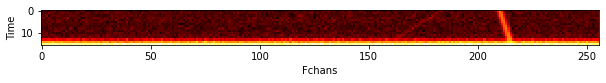

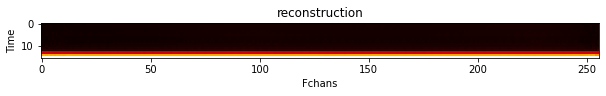

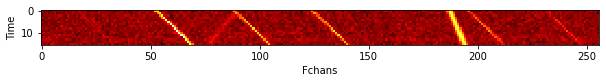

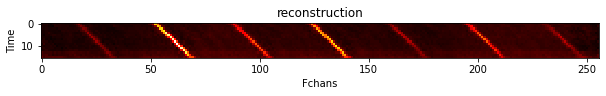

In [93]:
%matplotlib inline
import random 
for i in range(10):
    index = int(random.random()*1000)
    plot_data = data[index:index+1,:,:]
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(plot_data[0,:,:,0], interpolation='nearest', cmap=plt.get_cmap('hot'))
    plt.show()
  
    stuff = model.encoder.predict(plot_data)
    sample = sample_creation(stuff)
    reconstruction = model.decoder.predict(sample)
    plt.figure(figsize=(10,4))
    plt.title("reconstruction")
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(reconstruction[0,:,:,0], interpolation='nearest', cmap=plt.get_cmap('hot'))
#     print("-----------------------------------------------")